In [1]:
import requests
import numpy as np
import pandas as pd
import pandas_profiling
import json
import os
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import norm
from datetime import datetime

%matplotlib inline

pd.options.display.max_columns = None

import statsmodels.api as sm # Provides cross-sectional models and methods
from statsmodels.graphics.api import abline_plot # Plots line given intercept and slope
from sklearn.metrics import mean_squared_error, r2_score # Rates how close regression line is to data
from sklearn.model_selection import train_test_split #  Splits data into training and test groups
from sklearn import linear_model, preprocessing # Ordinary least square regression and standardizes the data
import warnings # For handling error messages.

In [2]:
os.chdir(r'C:\Users\2bogu\OneDrive\Desktop\Sringboard_Materials\capstone2\data\external')

df = pd.read_csv('Green_Jobs_-_Green_New_York__GJGNY__Residential_Loan_Portfolio___Beginning_November_2010.csv')

# Initial Cleaning

In [3]:
df['CANCEL REASON'].fillna('NONE', inplace = True)

In [4]:
df['ACCOUNT CODE'].value_counts()

SurePay/Automatic Debit Payment              12061
Check/Money Order Payment (with coupon)       9612
Paid in Full                                  4903
Legal Category                                 368
Notice of Bankruptcy (written)                 186
Canceled                                       160
Soft Hold                                       66
On Hold                                         16
Management Hold                                  5
Notice of Bankruptcy (verbal)                    4
Collections Terminated (by customer)             2
Dispute of Debt                                  1
SurePay/Automatic Debit Payment (on hold)        1
Name: ACCOUNT CODE, dtype: int64

In [5]:
# FILTERING FOR FINISHED LOANS
df = df.loc[df['ACCOUNT CODE'].str.contains('Hold|Canceled|Terminated|Bankruptcy|Full', regex=True)]

In [6]:
# creates dependent var
#df['bad'] = df['CANCEL REASON'].str.contains('NONE')
df['bad'] = df['ACCOUNT CODE'].str.contains('Hold|Canceled|Terminated|Bankruptcy', regex=True)
df['bad'] = df['bad'].apply(lambda x: 1 if x==True else 0)

In [7]:
df.describe()

,ORIGINAL LOAN AMOUNT,ORIGINAL TERM,INTEREST RATE,CREDIT SCORE CURRENT HIGH,CREDIT SCORE,CREDIT SCORE NAME 2,DEBT TO INCOME,LAST PAYMENT AMOUNT,PAYMENT AMOUNT,CURRENT BALANCE,UNAPPLIED CASH,DELINQUENT AMOUNT,TOTAL INTEREST PAID,TOTAL LATE CHARGE PAID,PAYMENTS REMAINING,DAYS DELINQUENT,INSTALLATION ZIP,Months Since Origination,Payments Made,bad
count,5342.000000,5342.000000,5342.000000,5211.000000,5203.000000,2217.000000,5216.000000,5342.000000,5342.000000,5342.000000,5342.000000,5342.000000,5342.000000,5342.000000,5342.000000,5342.000000,5342.000000,5342.000000,5342.000000,5342.000000
mean,10076.636887,150.875515,3.769296,756.387258,750.847011,752.165990,0.297223,3101.755301,91.328793,562.756732,0.439723,166.179925,766.223044,4.801945,10.114751,63.203482,12816.788656,65.619993,140.760277,0.082179
std,6337.052334,47.812924,0.902968,47.928979,49.583665,50.608994,0.525935,5134.298407,59.209793,2424.321083,6.397582,895.450150,720.733053,24.275473,36.912038,304.857586,1305.580984,23.999321,56.287322,0.274663
min,61.000000,26.000000,2.990000,527.000000,527.000000,495.000000,0.000000,0.000000,11.000000,0.000000,0.000000,-91.000000,-99.000000,0.000000,0.000000,-3375.000000,10027.000000,2.000000,0.000000,0.000000
25%,5020.250000,120.000000,3.490000,731.000000,721.000000,726.000000,0.160000,77.250000,48.000000,0.000000,0.000000,0.000000,242.000000,0.000000,0.000000,-24.000000,11754.000000,49.000000,60.000000,0.000000
50%,8386.000000,180.000000,3.490000,772.000000,767.000000,769.000000,0.280000,220.000000,78.000000,0.000000,0.000000,0.000000,547.000000,0.000000,0.000000,-7.000000,12866.000000,63.000000,180.000000,0.000000
75%,13431.500000,180.000000,3.490000,792.000000,789.000000,790.000000,0.400000,4173.000000,123.000000,0.000000,0.000000,0.000000,1087.500000,0.000000,0.000000,7.000000,14120.000000,85.000000,180.000000,0.000000
max,25000.000000,180.000000,8.490000,837.000000,837.000000,833.000000,36.090000,25525.000000,455.000000,25000.000000,153.000000,15558.000000,5534.000000,1081.000000,180.000000,2943.000000,14905.000000,114.000000,180.000000,1.000000


In [8]:
df['TYPE OF BANKRUPTCY'].fillna('NONE', inplace = True)

df['SUCCESSOR NUMBER'].fillna('NONE', inplace = True)
# successors didnt originall apply to to the program
df = df[df['SUCCESSOR NUMBER']=='NONE']
df.drop('SUCCESSOR NUMBER', axis=1, inplace=True)

# no data collected on health
df = df[df['CANCEL REASON'] != 'DEATH']

In [9]:
# indicates if loan has a cosigner
df['co-signed'] = np.where(pd.notnull(df['CREDIT SCORE NAME 2']), 1, 0)

# indicates if loan has a cosigner
df['co-signed'] = np.where(pd.notnull(df['CREDIT SCORE NAME 2']), 1, 0)

# averages credit score feature to get rid of nans in credit score 2
df['avg_credit_score'] = df[['CREDIT SCORE', 'CREDIT SCORE NAME 2']].mean(axis=1)

# fills remaining na values with average of averages
df['avg_credit_score'].fillna(df['avg_credit_score'].mean(), inplace=True)

df.drop(['CREDIT SCORE','CREDIT SCORE NAME 2'], axis=1, inplace=True)

In [10]:
# one instance of a 30 debt to income ratio is removed

df = df[df['DEBT TO INCOME'] < 30]

In [11]:
df['bad'].value_counts()

0    4499
1     314
Name: bad, dtype: int64

In [12]:
# maybe needed
df['Reporting Period'] = pd.to_datetime(df['Reporting Period'], format="%m/%d/%Y")
df['CONTRACT DATE'] = pd.to_datetime(df['CONTRACT DATE'], format="%m/%d/%Y")
df['SETUP DATE'] = pd.to_datetime(df['SETUP DATE'], format="%m/%d/%Y")
df['ORIGINAL MATURITY DATE'] = pd.to_datetime(df['ORIGINAL MATURITY DATE'], format="%m/%d/%Y")
df['CURRENT MATURITY DATE'] = pd.to_datetime(df['CURRENT MATURITY DATE'], format="%m/%d/%Y")
df['ACCOUNT CODE DATE'] = pd.to_datetime(df['ACCOUNT CODE DATE'], format="%m/%d/%Y")

In [13]:
#df['s_y'] = df['SETUP DATE'].apply(lambda x: x.year)

In [14]:
#df[df['s_y']==2020]

In [15]:
df = df.drop(['LAST PAYMENT AMOUNT', 'LAST PAYMENT DATE', 'FIRST PAYMENT DATE', 
              'DELINQUENT AMOUNT', 'DAYS DELINQUENT', 'Reporting Period', 
              'CREDIT SCORE CURRENT HIGH', 'NEXT PAYMENT DUE DATE', 'PAYMENTS REMAINING', 
              'PROPERTY COUNTY', 'UTILITY', 'INSTALLATION CITY', 'INSTALLATION ZIP', 
              'Contractor Name', 'Georeference', 'UNAPPLIED CASH', 'TOTAL LATE CHARGE PAID', 
              'CURRENT BALANCE', 'TOTAL INTEREST PAID', 'Payments Made'], axis=1)

# A little EDA

In [16]:
def diff_month(d1, d2):
    return abs((d1.year - d2.year) * 12) + abs(d1.month - d2.month)

def to_quart(d):
    qu = math.ceil(d.month/4)

In [17]:
def time_active(df):
    if (df['ACCOUNT CODE']=='Paid in Full') | (df['bad']==1):
        return diff_month(df['ACCOUNT CODE DATE'], df['SETUP DATE'])
    else:
        return df['Months Since Origination']

In [18]:
# to find out how long it took for loans get current account code 
# can only tell when a loan was cancelled, NOT how long a good loan has been active
# for age of good loans use Months Since Origination
df['active_m'] = df.apply(lambda x: time_active(x), axis=1)

## All

In [19]:
df.describe()

,ORIGINAL LOAN AMOUNT,ORIGINAL TERM,INTEREST RATE,DEBT TO INCOME,PAYMENT AMOUNT,Months Since Origination,bad,co-signed,avg_credit_score,active_m
count,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000
mean,10033.711407,148.870974,3.800721,0.287480,92.366312,65.535612,0.065240,0.425722,752.012580,39.976522
std,6272.440885,49.411627,0.928285,0.174204,60.264771,24.415961,0.246974,0.494503,48.313137,23.451451
min,1472.000000,60.000000,2.990000,0.000000,11.000000,2.000000,0.000000,0.000000,527.000000,0.000000
25%,5021.000000,120.000000,3.490000,0.160000,48.000000,49.000000,0.000000,0.000000,725.000000,21.000000
50%,8331.000000,180.000000,3.490000,0.280000,79.000000,63.000000,0.000000,0.000000,767.000000,39.000000
75%,13250.000000,180.000000,3.990000,0.400000,124.000000,86.000000,0.000000,1.000000,789.000000,60.000000
max,25000.000000,180.000000,8.490000,1.000000,455.000000,114.000000,1.000000,1.000000,833.000000,131.000000


<AxesSubplot:>

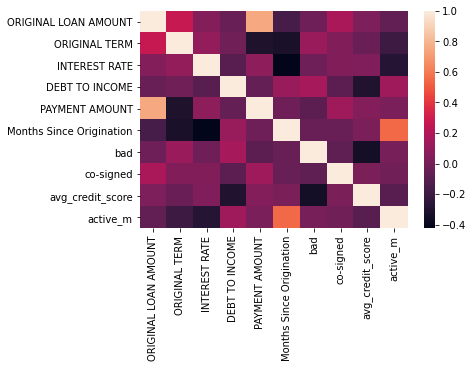

In [20]:
sns.heatmap(df.corr())

array([[<AxesSubplot:title={'center':'CONTRACT DATE'}>,
        <AxesSubplot:title={'center':'SETUP DATE'}>,
        <AxesSubplot:title={'center':'ORIGINAL LOAN AMOUNT'}>,
        <AxesSubplot:title={'center':'ORIGINAL TERM'}>],
       [<AxesSubplot:title={'center':'ORIGINAL MATURITY DATE'}>,
        <AxesSubplot:title={'center':'CURRENT MATURITY DATE'}>,
        <AxesSubplot:title={'center':'INTEREST RATE'}>,
        <AxesSubplot:title={'center':'DEBT TO INCOME'}>],
       [<AxesSubplot:title={'center':'PAYMENT AMOUNT'}>,
        <AxesSubplot:title={'center':'ACCOUNT CODE DATE'}>,
        <AxesSubplot:title={'center':'Months Since Origination'}>,
        <AxesSubplot:title={'center':'bad'}>],
       [<AxesSubplot:title={'center':'co-signed'}>,
        <AxesSubplot:title={'center':'avg_credit_score'}>,
        <AxesSubplot:title={'center':'active_m'}>, <AxesSubplot:>]],
      dtype=object)

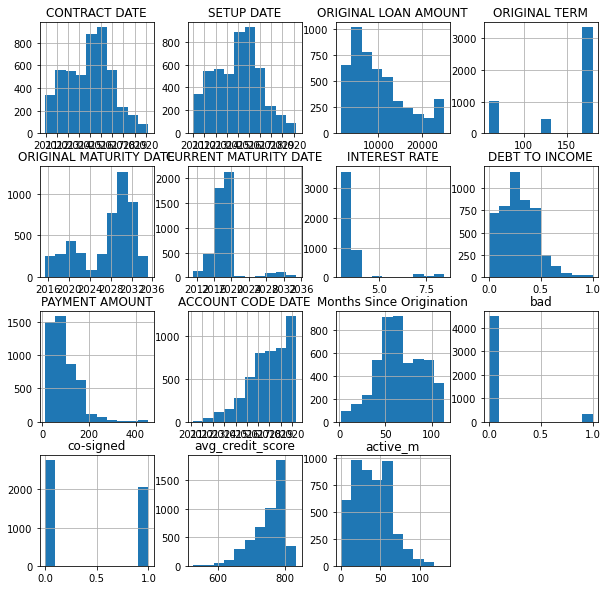

In [21]:
df.hist(figsize=(10,10))

## Good

In [22]:
df_g = df[df['bad']==0]

In [23]:
df_g.describe()

,ORIGINAL LOAN AMOUNT,ORIGINAL TERM,INTEREST RATE,DEBT TO INCOME,PAYMENT AMOUNT,Months Since Origination,bad,co-signed,avg_credit_score,active_m
count,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.0,4499.000000,4499.000000,4499.000000
mean,10064.963770,147.271838,3.806515,0.279963,93.705948,65.831718,0.0,0.435208,756.477006,39.936875
std,6312.848549,50.301427,0.947051,0.170558,61.087730,24.212773,0.0,0.495839,44.221411,23.564336
min,1472.000000,60.000000,2.990000,0.000000,11.000000,2.000000,0.0,0.000000,544.000000,0.000000
25%,5005.000000,120.000000,3.490000,0.150000,49.000000,49.000000,0.0,0.000000,732.500000,20.000000
50%,8365.000000,180.000000,3.490000,0.270000,80.000000,63.000000,0.0,0.000000,770.000000,39.000000
75%,13321.000000,180.000000,3.990000,0.390000,126.000000,86.000000,0.0,1.000000,790.000000,60.000000
max,25000.000000,180.000000,8.490000,1.000000,455.000000,114.000000,0.0,1.000000,833.000000,131.000000


<AxesSubplot:>

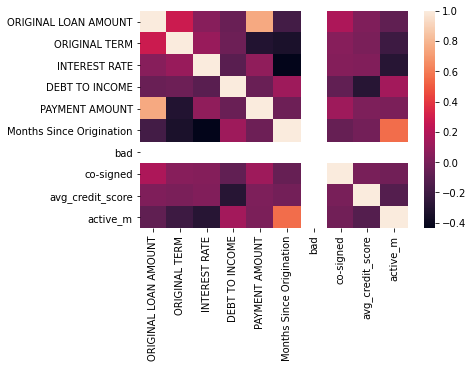

In [24]:
sns.heatmap(df_g.corr())

array([[<AxesSubplot:title={'center':'CONTRACT DATE'}>,
        <AxesSubplot:title={'center':'SETUP DATE'}>,
        <AxesSubplot:title={'center':'ORIGINAL LOAN AMOUNT'}>,
        <AxesSubplot:title={'center':'ORIGINAL TERM'}>],
       [<AxesSubplot:title={'center':'ORIGINAL MATURITY DATE'}>,
        <AxesSubplot:title={'center':'CURRENT MATURITY DATE'}>,
        <AxesSubplot:title={'center':'INTEREST RATE'}>,
        <AxesSubplot:title={'center':'DEBT TO INCOME'}>],
       [<AxesSubplot:title={'center':'PAYMENT AMOUNT'}>,
        <AxesSubplot:title={'center':'ACCOUNT CODE DATE'}>,
        <AxesSubplot:title={'center':'Months Since Origination'}>,
        <AxesSubplot:title={'center':'bad'}>],
       [<AxesSubplot:title={'center':'co-signed'}>,
        <AxesSubplot:title={'center':'avg_credit_score'}>,
        <AxesSubplot:title={'center':'active_m'}>, <AxesSubplot:>]],
      dtype=object)

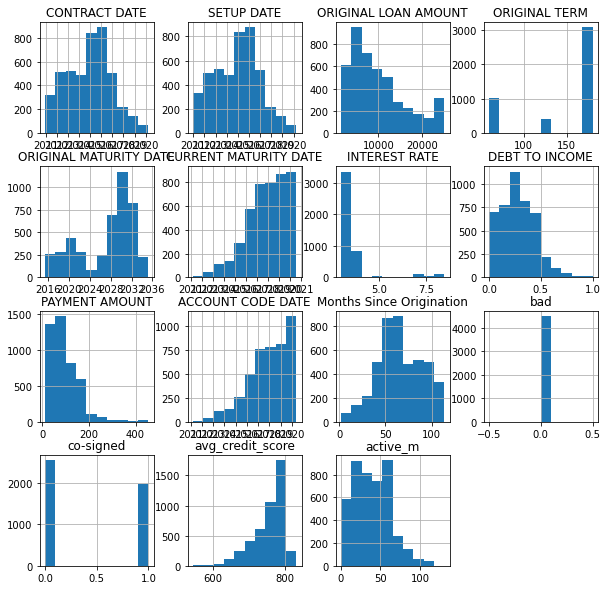

In [25]:
df_g.hist(figsize=(10,10))

## Bad

In [26]:
df_b = df[df['bad']==1]

In [27]:
df_b.describe()

,ORIGINAL LOAN AMOUNT,ORIGINAL TERM,INTEREST RATE,DEBT TO INCOME,PAYMENT AMOUNT,Months Since Origination,bad,co-signed,avg_credit_score,active_m
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.0,314.000000,314.000000,314.000000
mean,9585.926752,171.783439,3.717707,0.395191,73.171975,61.292994,1.0,0.289809,688.046178,40.544586
std,5652.075967,24.715717,0.592738,0.189887,42.577976,26.846210,0.0,0.454398,58.236095,21.797051
min,1748.000000,60.000000,2.990000,0.000000,12.000000,6.000000,1.0,0.000000,527.000000,0.000000
25%,5098.500000,180.000000,3.490000,0.260000,39.250000,42.000000,1.0,0.000000,657.000000,24.000000
50%,8001.500000,180.000000,3.490000,0.400000,63.000000,60.000000,1.0,0.000000,692.000000,38.000000
75%,12988.500000,180.000000,3.990000,0.490000,95.000000,84.000000,1.0,1.000000,726.000000,55.000000
max,25000.000000,180.000000,7.990000,0.980000,231.000000,111.000000,1.0,1.000000,833.000000,105.000000


<AxesSubplot:>

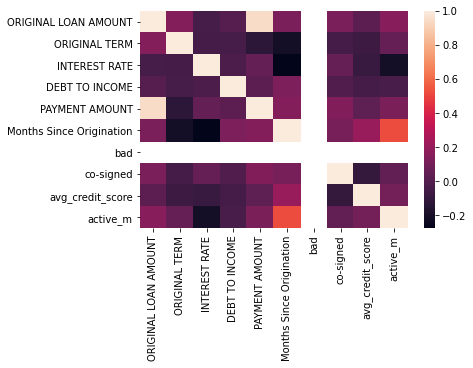

In [28]:
sns.heatmap(df_b.corr())

array([[<AxesSubplot:title={'center':'CONTRACT DATE'}>,
        <AxesSubplot:title={'center':'SETUP DATE'}>,
        <AxesSubplot:title={'center':'ORIGINAL LOAN AMOUNT'}>,
        <AxesSubplot:title={'center':'ORIGINAL TERM'}>],
       [<AxesSubplot:title={'center':'ORIGINAL MATURITY DATE'}>,
        <AxesSubplot:title={'center':'CURRENT MATURITY DATE'}>,
        <AxesSubplot:title={'center':'INTEREST RATE'}>,
        <AxesSubplot:title={'center':'DEBT TO INCOME'}>],
       [<AxesSubplot:title={'center':'PAYMENT AMOUNT'}>,
        <AxesSubplot:title={'center':'ACCOUNT CODE DATE'}>,
        <AxesSubplot:title={'center':'Months Since Origination'}>,
        <AxesSubplot:title={'center':'bad'}>],
       [<AxesSubplot:title={'center':'co-signed'}>,
        <AxesSubplot:title={'center':'avg_credit_score'}>,
        <AxesSubplot:title={'center':'active_m'}>, <AxesSubplot:>]],
      dtype=object)

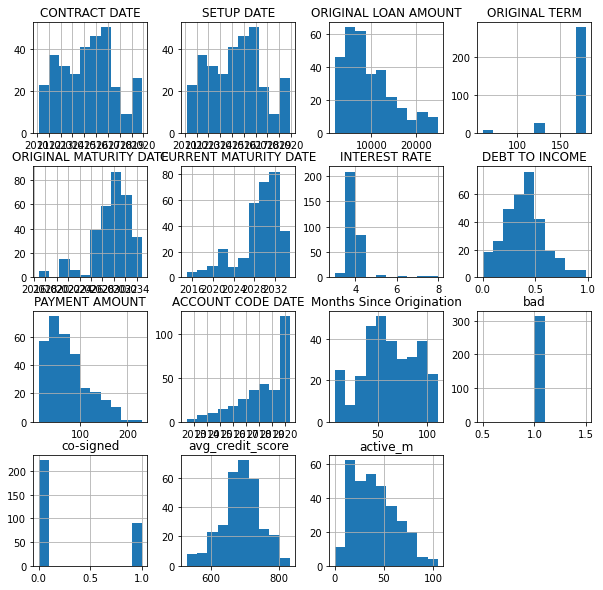

In [29]:
df_b.hist(figsize=(10,10))

# Defining the positive Class

In [30]:
import math
df_b['y'] = df_b['ACCOUNT CODE DATE'].apply(lambda x: x.year)

C:\Users\2bogu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

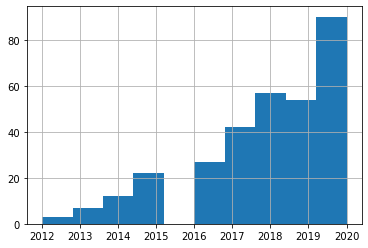

In [31]:
df_b['y'].hist()

<AxesSubplot:>

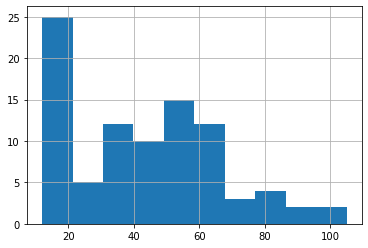

In [32]:
#loans that have gone bad in 2020
df_b[df_b['y']==2020]['active_m'].hist()

<AxesSubplot:>

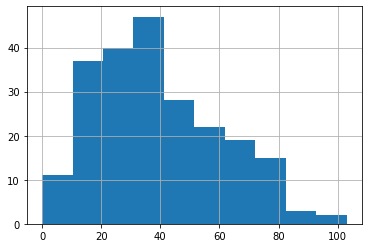

In [33]:
#oans that have gone bad before 2020
df_b[df_b['y']!=2020]['active_m'].hist()

##### The economic impact of COVID could cause people who would otherwise had paid off their loans to slip into bad standing.  This data represents only 5 months into 2020.  

___H-null___ : There is no difference in how long it took for a loan to become 'bad' loans between 2020 and other years ___Rejected(?)___

- doubling y_2020 to simulate a full year

In [34]:
y_2020 = df_b[df_b['y']==2020]['active_m']

y_2020_ = y_2020.copy()

y_2020 = y_2020.append(y_2020_, ignore_index=True)
 
y_19 = df_b[df_b['y']!=2020]['active_m']

scipy.stats.ttest_ind(y_2020, y_19)

Ttest_indResult(statistic=1.989517752644897, pvalue=0.047321254530316166)

##### Its right on the line.  Doubling the amount of bad loans doubles both loans that have gone bad due to covid as well as loans that would have gone bad anyway.  In theory this mean the t-stat and p-value would be stronger.  They will be kept in this copy



# Defining the Negative class

## Determining threshold for loans of good standing

### DOES NOT APPLY TO THIS COPY

##### If we only include completed loans the model will not generalize well because it will be fit only on outliers.  These are 10-20 year loans and we only have 9 years of data.  The model must be able to distinguish between a typical loan and one that will fail.  It won't be able to do this if it only has extraordinary cases to train on.  When does it become safe to assume a loan will be paid off?

In [35]:
df_b = df[df['bad']==1]

In [36]:
import math
df_b['y'] = df_b['ACCOUNT CODE DATE'].apply(lambda x: x.year)

C:\Users\2bogu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

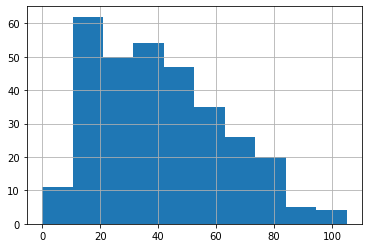

In [37]:
df_b['active_m'].hist()

#q = df[df['bad']==1]['active_m'].quantile(0.95)

In [38]:
bad_mean = np.mean(df_b.active_m)
bad_std = np.std(df_b.active_m, ddof=1)

bad_mean, bad_std

(40.544585987261144, 21.797050815854433)

In [39]:
df_b.active_m.quantile(q=0.99)

94.87

In [40]:
1 - norm.cdf(95, loc=bad_mean, scale=bad_std)

0.006239654464996192

In [41]:
len(df[(df['bad'] == 0) & (df['active_m'] >= 95)])

90

df = df[(df['bad'] == 1) | 
        (df['ACCOUNT CODE'] == 'Paid in Full') |
        ((df['bad'] == 0) & (df['active_m'] >= 99))]

In [42]:
len(df)

4813

##### The number of months it takes for loans to fail is not normally distributed, so it was boostrapped with the expected mean falling within the confidence interval of the true mean.  According to that re-sampled data, there is P=0.006 chance that a loan will be canceled at or after the 99th percentile, 95 months.  We will keep loans that have been active for 95 months or more to give the model a sense of what a typical profile is, not just ones that are repaid quickly.


##### This ends up adding 1038 loans for a totla of 5503
    
   
##### Could potentially also exclude loans that were paid off a little too quickly...
    

## Defining threshold for paid off loans

##### A ten year loan thats paid off in just a couple of months is generally atypical, except in this dataset.  If there was 3rd party involvement to make this happen, and if this played a role in determining if the loan was approved or not is unknown.  There is an abundance of paid off loans compared to canceled loans and 'safe' long standing loans so defining a threshold seems to make sense.


### Sample pop = Paid off loans

In [43]:
df_g = df[df['ACCOUNT CODE']=='Paid in Full']

<AxesSubplot:>

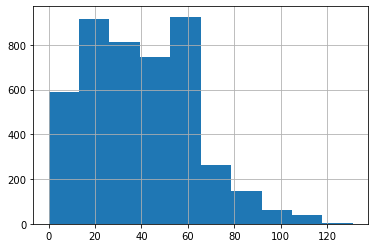

In [44]:
df_g['active_m'].hist()

In [45]:
good_mean = np.mean(df_g.active_m)
good_std = np.std(df_g.active_m, ddof=1)

good_mean, good_std

(39.93687486108024, 23.564335708841078)

In [46]:
df_g.active_m.quantile(0.025)

1.0

In [47]:
norm.cdf(1, loc=good_mean, scale=good_std)

0.04923012065412631

In [48]:
len(df[((df['ACCOUNT CODE'] == 'Paid in Full') & (df['active_m'] < 1))])

49

##### The p value is just barely acceptable and removes 49 loans that were paid off before a month had passed

##### MAKING NO ALTERATIONS THIS COPY

df = df[(df['ACCOUNT CODE']!= 'Paid in Full') |
        ((df['ACCOUNT CODE'] == 'Paid in Full') & (df['active_m'] >= 1))]

# A little more EDA

In [49]:
df_b = df[(df['bad'] == 1)]
df_g = df[df['bad'] != 1]

##### Based on the histograms of each group bellow it seems it could be better to create a flag for original term length

## Redoing the initial EDA, not relevent this copy

### All

In [50]:
df.describe()

,ORIGINAL LOAN AMOUNT,ORIGINAL TERM,INTEREST RATE,DEBT TO INCOME,PAYMENT AMOUNT,Months Since Origination,bad,co-signed,avg_credit_score,active_m
count,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000
mean,10033.711407,148.870974,3.800721,0.287480,92.366312,65.535612,0.065240,0.425722,752.012580,39.976522
std,6272.440885,49.411627,0.928285,0.174204,60.264771,24.415961,0.246974,0.494503,48.313137,23.451451
min,1472.000000,60.000000,2.990000,0.000000,11.000000,2.000000,0.000000,0.000000,527.000000,0.000000
25%,5021.000000,120.000000,3.490000,0.160000,48.000000,49.000000,0.000000,0.000000,725.000000,21.000000
50%,8331.000000,180.000000,3.490000,0.280000,79.000000,63.000000,0.000000,0.000000,767.000000,39.000000
75%,13250.000000,180.000000,3.990000,0.400000,124.000000,86.000000,0.000000,1.000000,789.000000,60.000000
max,25000.000000,180.000000,8.490000,1.000000,455.000000,114.000000,1.000000,1.000000,833.000000,131.000000


<AxesSubplot:>

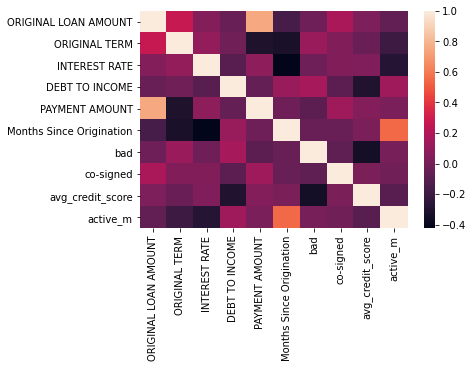

In [51]:
sns.heatmap(df.corr())

array([[<AxesSubplot:title={'center':'CONTRACT DATE'}>,
        <AxesSubplot:title={'center':'SETUP DATE'}>,
        <AxesSubplot:title={'center':'ORIGINAL LOAN AMOUNT'}>,
        <AxesSubplot:title={'center':'ORIGINAL TERM'}>],
       [<AxesSubplot:title={'center':'ORIGINAL MATURITY DATE'}>,
        <AxesSubplot:title={'center':'CURRENT MATURITY DATE'}>,
        <AxesSubplot:title={'center':'INTEREST RATE'}>,
        <AxesSubplot:title={'center':'DEBT TO INCOME'}>],
       [<AxesSubplot:title={'center':'PAYMENT AMOUNT'}>,
        <AxesSubplot:title={'center':'ACCOUNT CODE DATE'}>,
        <AxesSubplot:title={'center':'Months Since Origination'}>,
        <AxesSubplot:title={'center':'bad'}>],
       [<AxesSubplot:title={'center':'co-signed'}>,
        <AxesSubplot:title={'center':'avg_credit_score'}>,
        <AxesSubplot:title={'center':'active_m'}>, <AxesSubplot:>]],
      dtype=object)

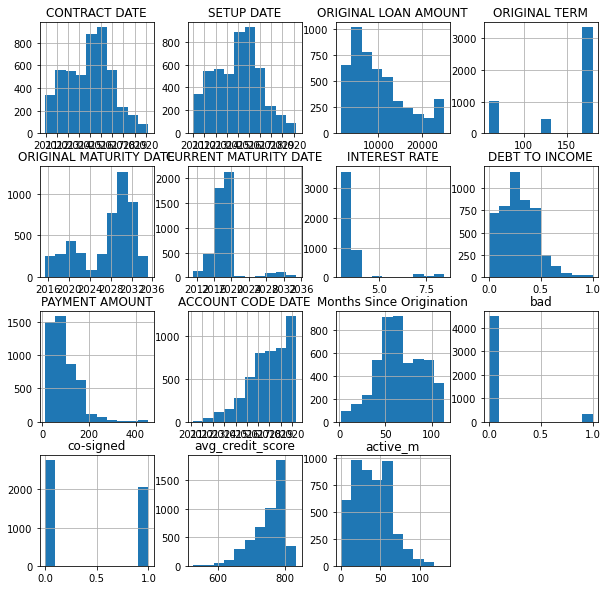

In [52]:
df.hist(figsize=(10,10))

### Good

In [53]:
#df_g.describe()

<AxesSubplot:>

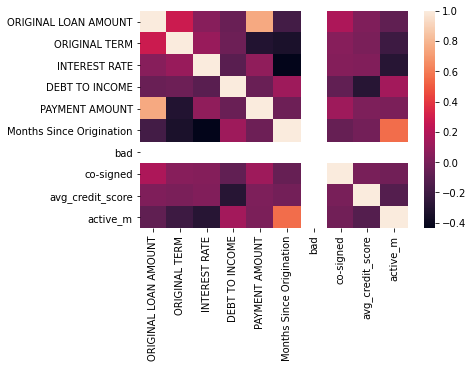

In [54]:
sns.heatmap(df_g.corr())

array([[<AxesSubplot:title={'center':'CONTRACT DATE'}>,
        <AxesSubplot:title={'center':'SETUP DATE'}>,
        <AxesSubplot:title={'center':'ORIGINAL LOAN AMOUNT'}>,
        <AxesSubplot:title={'center':'ORIGINAL TERM'}>],
       [<AxesSubplot:title={'center':'ORIGINAL MATURITY DATE'}>,
        <AxesSubplot:title={'center':'CURRENT MATURITY DATE'}>,
        <AxesSubplot:title={'center':'INTEREST RATE'}>,
        <AxesSubplot:title={'center':'DEBT TO INCOME'}>],
       [<AxesSubplot:title={'center':'PAYMENT AMOUNT'}>,
        <AxesSubplot:title={'center':'ACCOUNT CODE DATE'}>,
        <AxesSubplot:title={'center':'Months Since Origination'}>,
        <AxesSubplot:title={'center':'bad'}>],
       [<AxesSubplot:title={'center':'co-signed'}>,
        <AxesSubplot:title={'center':'avg_credit_score'}>,
        <AxesSubplot:title={'center':'active_m'}>, <AxesSubplot:>]],
      dtype=object)

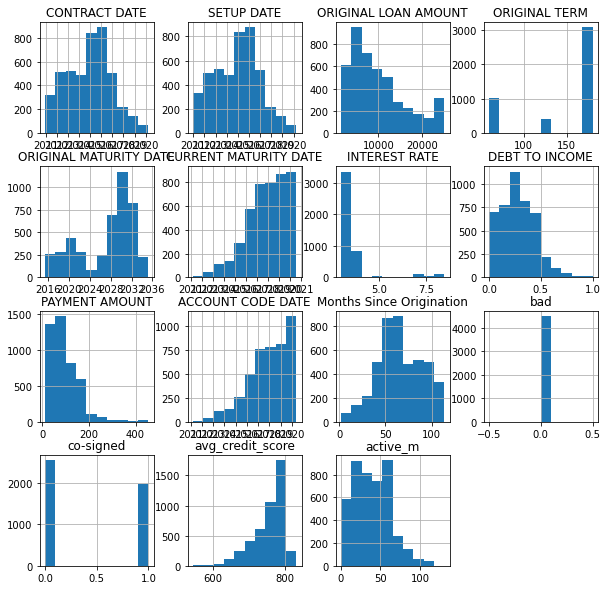

In [55]:
df_g.hist(figsize=(10,10))

### Bad

In [56]:
#df_b.describe()

<AxesSubplot:>

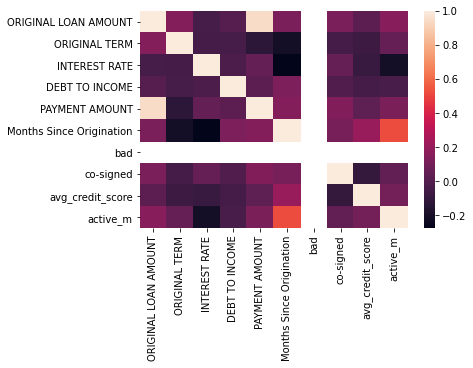

In [57]:
sns.heatmap(df_b.corr())

array([[<AxesSubplot:title={'center':'CONTRACT DATE'}>,
        <AxesSubplot:title={'center':'SETUP DATE'}>,
        <AxesSubplot:title={'center':'ORIGINAL LOAN AMOUNT'}>,
        <AxesSubplot:title={'center':'ORIGINAL TERM'}>],
       [<AxesSubplot:title={'center':'ORIGINAL MATURITY DATE'}>,
        <AxesSubplot:title={'center':'CURRENT MATURITY DATE'}>,
        <AxesSubplot:title={'center':'INTEREST RATE'}>,
        <AxesSubplot:title={'center':'DEBT TO INCOME'}>],
       [<AxesSubplot:title={'center':'PAYMENT AMOUNT'}>,
        <AxesSubplot:title={'center':'ACCOUNT CODE DATE'}>,
        <AxesSubplot:title={'center':'Months Since Origination'}>,
        <AxesSubplot:title={'center':'bad'}>],
       [<AxesSubplot:title={'center':'co-signed'}>,
        <AxesSubplot:title={'center':'avg_credit_score'}>,
        <AxesSubplot:title={'center':'active_m'}>, <AxesSubplot:>]],
      dtype=object)

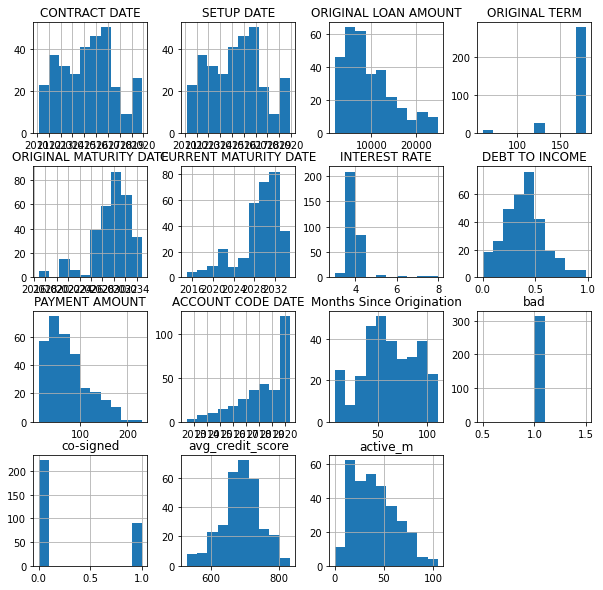

In [58]:
df_b.hist(figsize=(10,10))

## Category EDA

In [59]:
df.select_dtypes(include='object').columns

Index(['ACCOUNT CODE', 'CANCEL REASON', 'TYPE OF BANKRUPTCY', 'Purpose',
       'Loan Type', 'Underwriting', 'Pledged'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

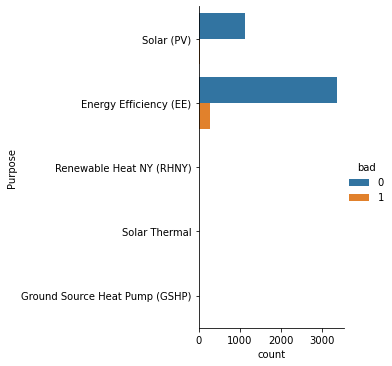

<Figure size 432x288 with 0 Axes>

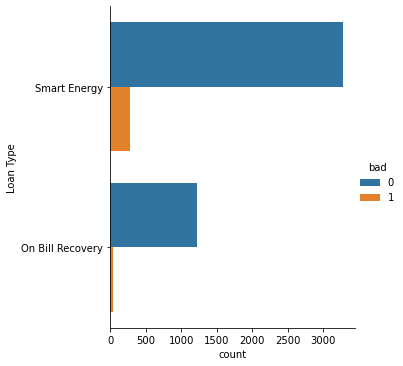

<Figure size 432x288 with 0 Axes>

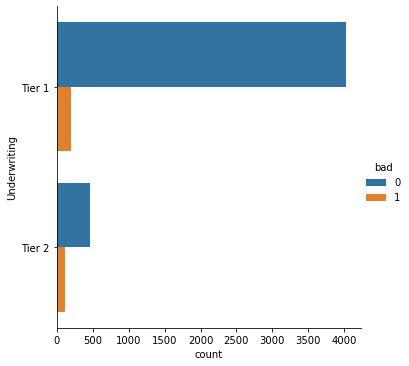

<Figure size 432x288 with 0 Axes>

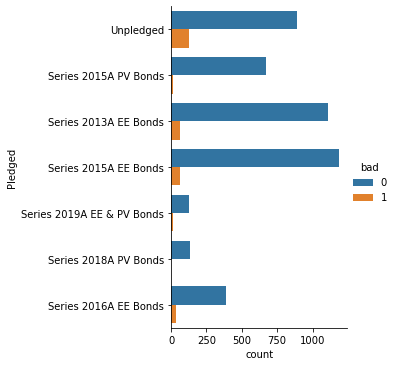

In [60]:
objs = ['Purpose','Loan Type', 'Underwriting', 'Pledged']

for o in objs:
    plt.figure()
    sns.catplot(y=o, data=df, kind='count', hue='bad')
    plt.show()

In [61]:
for o in objs:
    print(o)
    print(df[o].value_counts())
    print('')

Purpose
Energy Efficiency (EE)            3654
Solar (PV)                        1150
Renewable Heat NY (RHNY)             5
Solar Thermal                        2
Ground Source Heat Pump (GSHP)       2
Name: Purpose, dtype: int64

Loan Type
Smart Energy        3557
On Bill Recovery    1256
Name: Loan Type, dtype: int64

Underwriting
Tier 1    4227
Tier 2     586
Name: Underwriting, dtype: int64

Pledged
Series 2015A EE Bonds         1251
Series 2013A EE Bonds         1172
Unpledged                     1018
Series 2015A PV Bonds          682
Series 2016A EE Bonds          418
Series 2019A EE & PV Bonds     137
Series 2018A PV Bonds          135
Name: Pledged, dtype: int64



## Scatter plots

<AxesSubplot:xlabel='avg_credit_score', ylabel='DEBT TO INCOME'>

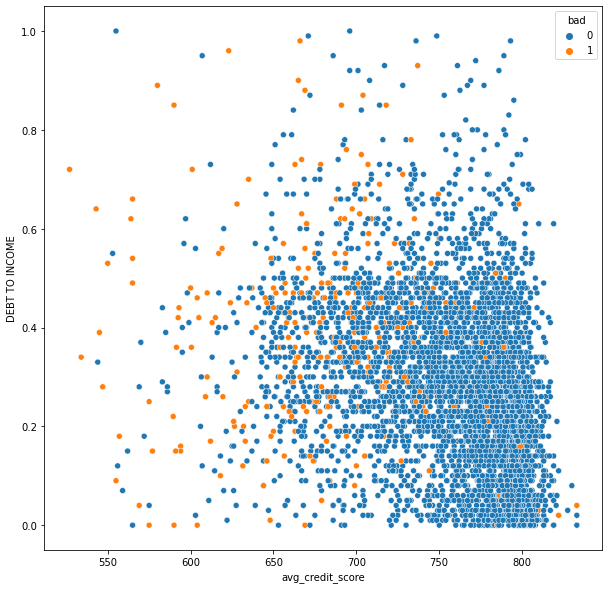

In [62]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='avg_credit_score', y='DEBT TO INCOME', data=df, hue='bad')

<AxesSubplot:xlabel='avg_credit_score', ylabel='ORIGINAL LOAN AMOUNT'>

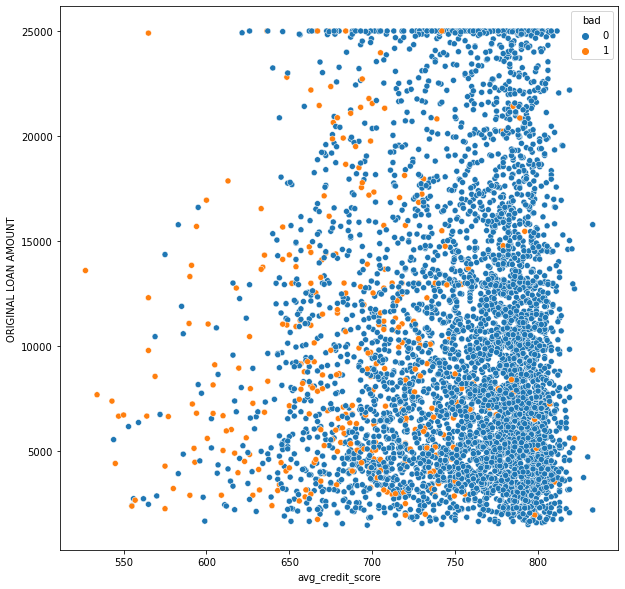

In [63]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='avg_credit_score', y='ORIGINAL LOAN AMOUNT', data=df, hue='bad')

<AxesSubplot:xlabel='avg_credit_score', ylabel='PAYMENT AMOUNT'>

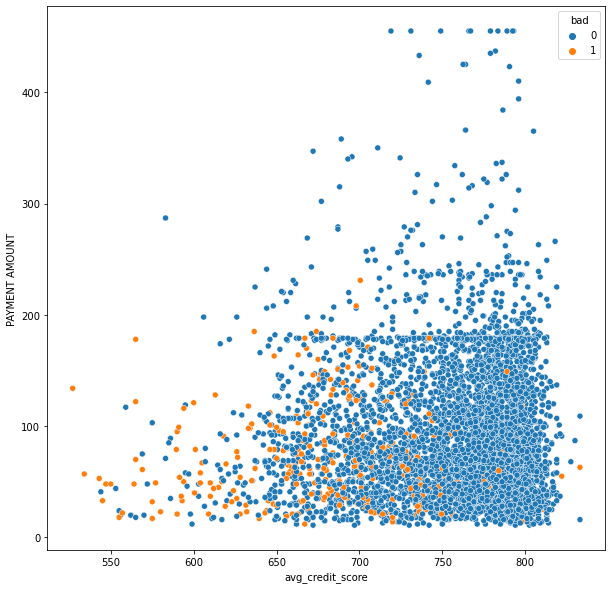

In [64]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='avg_credit_score', y='PAYMENT AMOUNT', data=df, hue='bad')

<AxesSubplot:xlabel='INTEREST RATE', ylabel='avg_credit_score'>

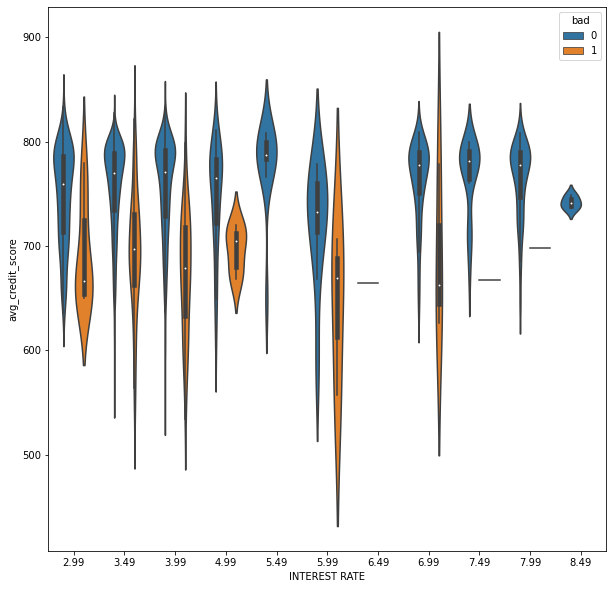

In [65]:
plt.figure(figsize=(10,10))
sns.violinplot(x='INTEREST RATE', y='avg_credit_score', data=df, hue='bad')

<AxesSubplot:xlabel='ORIGINAL TERM', ylabel='avg_credit_score'>

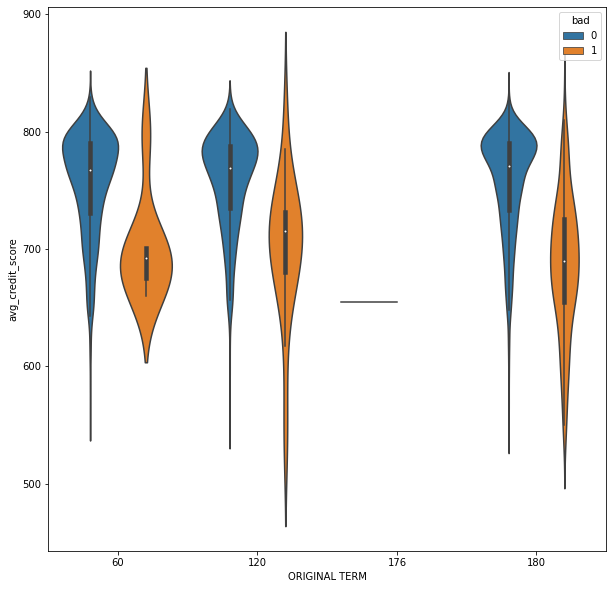

In [66]:
plt.figure(figsize=(10,10))
sns.violinplot(x='ORIGINAL TERM', y='avg_credit_score', data=df, hue='bad')

In [67]:
df.columns

Index(['CONTRACT DATE', 'SETUP DATE', 'ORIGINAL LOAN AMOUNT', 'ORIGINAL TERM',
       'ORIGINAL MATURITY DATE', 'CURRENT MATURITY DATE', 'INTEREST RATE',
       'DEBT TO INCOME', 'PAYMENT AMOUNT', 'ACCOUNT CODE', 'ACCOUNT CODE DATE',
       'CANCEL REASON', 'TYPE OF BANKRUPTCY', 'Months Since Origination',
       'Purpose', 'Loan Type', 'Underwriting', 'Pledged', 'bad', 'co-signed',
       'avg_credit_score', 'active_m'],
      dtype='object')

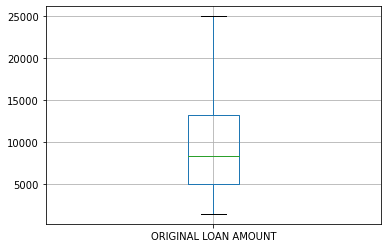

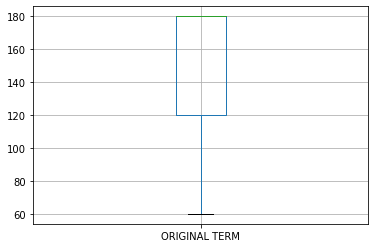

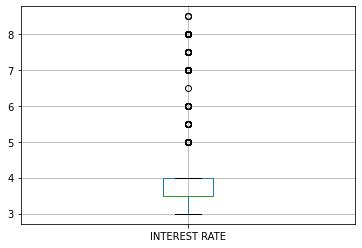

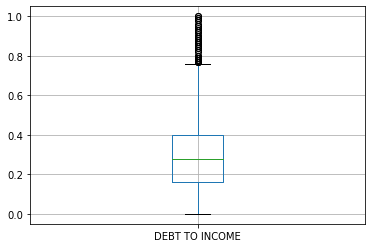

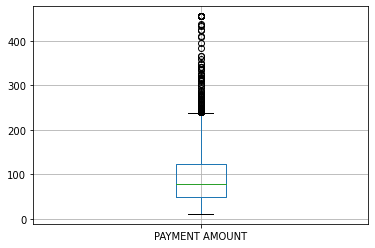

In [68]:
bx = ['ORIGINAL LOAN AMOUNT','ORIGINAL TERM','INTEREST RATE','DEBT TO INCOME','PAYMENT AMOUNT']

for b in bx:
    pd.DataFrame(df[b]).boxplot()
    plt.show()

# Category Binarification

In [69]:
# CREATES BINARY COLUMN FOR PLEDGED VS UNPLEDGED LOANS
df['unpledged'] = df['Pledged'].apply(lambda x: 1 if x == 'Unpledged' else 0)

# DROPS ORIGINAL PLEDGED COLUMN
df.drop('Pledged', axis=1, inplace=True)

In [70]:
# CREATES FLAG FOR UNDERWRITTING T1, ONLY T1 AND T2 IN SET
df['underwritten_t1'] = df['Underwriting'].apply(lambda x: 1 if x == 'Tier 1' else 0)

df.drop('Underwriting', axis=1, inplace=True)

In [71]:
# CREATES BOOL FOR LOAN TYPE, 0 = ON BILL RECOVERY
df['loan_type_smart_energy'] = df['Loan Type'].apply(lambda x: 1 if x == 'Smart Energy' else 0)

df.drop('Loan Type', axis= 1, inplace=True)

In [72]:
# CREATES BOOL FOR PURPOSE, DOUBLE ZERO IS OTHER
df['purpose_ee'] = df['Purpose'].apply(lambda x: 1 if x == 'Energy Efficiency (EE)' else 0)

df['purpose_sol'] = df['Purpose'].apply(lambda x: 1 if x == 'Solar (PV)' else 0)

df.drop('Purpose', axis=1, inplace=True)

In [73]:
df.drop([
    'CONTRACT DATE', 'SETUP DATE', 'ORIGINAL MATURITY DATE',
    'CURRENT MATURITY DATE', 'ACCOUNT CODE', 'ACCOUNT CODE DATE',
    'CANCEL REASON', 'TYPE OF BANKRUPTCY','active_m','Months Since Origination' #,'y'
],
        axis=1,
        inplace=True)

In [74]:
df['ORIGINAL TERM'].value_counts()

180    3346
60     1031
120     435
176       1
Name: ORIGINAL TERM, dtype: int64

In [75]:
# dtype int, but is a category. tricky tricky
df['term_180'] = df['ORIGINAL TERM'].apply(lambda x: 1 if x==180 else 0)
df['term_120'] = df['ORIGINAL TERM'].apply(lambda x: 1 if x==120 else 0)
df['term_60'] = df['ORIGINAL TERM'].apply(lambda x: 1 if x==60 else 0)

df.drop('ORIGINAL TERM',axis=1,inplace=True)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4813 entries, 0 to 27357
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ORIGINAL LOAN AMOUNT    4813 non-null   float64
 1   INTEREST RATE           4813 non-null   float64
 2   DEBT TO INCOME          4813 non-null   float64
 3   PAYMENT AMOUNT          4813 non-null   float64
 4   bad                     4813 non-null   int64  
 5   co-signed               4813 non-null   int32  
 6   avg_credit_score        4813 non-null   float64
 7   unpledged               4813 non-null   int64  
 8   underwritten_t1         4813 non-null   int64  
 9   loan_type_smart_energy  4813 non-null   int64  
 10  purpose_ee              4813 non-null   int64  
 11  purpose_sol             4813 non-null   int64  
 12  term_180                4813 non-null   int64  
 13  term_120                4813 non-null   int64  
 14  term_60                 4813 non-null  

In [77]:
(sum(df.bad))
#/len(df)

314

In [78]:
#
len(df)- sum(df.bad) 


4499

# Conclusion

##### Rows: 4813
##### Columns: 15 : 5 numeric, 10 binary categorical leave one out
##### Positive Class: 314(%6.5) : All loans that have been canceled by the original clients of GJGNY for a reason other than death or put on hold, and did not go bad in 2020
##### Negative Class: 4499: All loans paid off after one month had passed and loans in good standing that have been active for 95 months or longer

In [80]:
df.to_csv(r'C:\Users\2bogu\OneDrive\Desktop\Sringboard_Materials\capstone2\data\interim\fl', index = False)